# Dataset

In [1]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = data['data']
Y = data['target']


In [2]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler

class Custom_Dataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        X_return = torch.tensor(self.X[idx], dtype = torch.float32)
        Y_return = torch.tensor(self.Y[idx], dtype = torch.float32).reshape(-1,1)
        return X_return, Y_return
        
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle = True)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, train_size = 0.8, shuffle = True)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)
X_val_scale = scaler.transform(X_val)

train_dataset = Custom_Dataset(X_train_scale, Y_train)
test_dataset = Custom_Dataset(X_test_scale, Y_test)
val_dataset = Custom_Dataset(X_val_scale, Y_val)

batch_size = 1

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)


# Deep Learning Model

In [3]:
import torch.nn as nn

class ANN_Model(nn.Module):
    def __init__(self, n_features, n_targets):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_features, 50),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(50,25),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(25, 12),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(12, n_targets),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

# Training

In [4]:
import torch
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
torch.cuda.empty_cache()

def train(model, loss_fn, lr, epochs, train_data, val_data, test_data):
    optimizer = optim.Adam(model.parameters(), lr = lr)
    scaler = torch.cuda.amp.GradScaler()
    lst_loss = []
    lst_accuracy = []
    mean_loss = 0
    mean_accuracy = 0
    lst_mean_loss = []
    lst_mean_accuracy = []
    val_lst_loss = []
    val_lst_accuracy = []
    val_mean_loss = 0
    val_mean_accuracy = 0
    val_lst_mean_loss = []
    val_lst_mean_accuracy = []
    test_lst_loss = []
    test_lst_accuracy = []
    test_mean_loss = 0
    test_mean_accuracy = 0
    test_lst_mean_loss = []
    test_lst_mean_accuracy = []
    for epoch in range(epochs):
        print("Epoch: ", epoch + 1)
        loop = tqdm(train_data)
        for mb, (x_input, y_output) in enumerate(loop, start = 1):
            model.train()
            x_input = x_input.to(device = device)
            y_output = y_output.to(device = device).reshape(-1,1)
            with torch.cuda.amp.autocast():
                prediction = model(x_input)
                loss = loss_fn(prediction, y_output)
                
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            loop.set_postfix(loss_function = loss.item())
            
        model.eval()
        lst_lost = []
        lst_accuracy = []
        for i, data in enumerate(train_data, 0):
            x_input, y_output = data
            x_input = x_input.to(device = device)
            y_output = y_output.to(device = device).reshape(-1,1)
            with torch.no_grad():
                prediction = model(x_input)
                loss = loss_fn(prediction, y_output)
                lst_loss.append(loss.item())
                y_output = y_output.cpu().numpy()
                prediction = prediction.round().cpu().numpy()
                accuracy = accuracy_score(y_output, prediction)
                lst_accuracy.append(accuracy)
                
        mean_loss = np.mean(lst_loss)
        lst_mean_loss.append(mean_loss)
        mean_accuracy = np.mean(lst_accuracy)
        lst_mean_accuracy.append(mean_accuracy)
        
        val_lst_loss = []
        val_lst_accuracy = []
        for i, data in enumerate(val_data, 0):
            x_input, y_output = data
            x_input = x_input.to(device = device)
            y_output = y_output.to(device = device).reshape(-1,1)
            with torch.no_grad():
                prediction = model(x_input)
                loss = loss_fn(prediction, y_output)
                val_lst_loss.append(loss.item())
                y_output = y_output.cpu().numpy()
                prediction = prediction.round().cpu().numpy()
                accuracy = accuracy_score(y_output, prediction)
                val_lst_accuracy.append(accuracy)
                
        val_mean_loss = np.mean(val_lst_loss)
        val_lst_mean_loss.append(val_mean_loss)
        val_mean_accuracy = np.mean(val_lst_accuracy)
        val_lst_mean_accuracy.append(val_mean_accuracy)
        
        test_lst_loss = []
        test_lst_accuracy = []
        for i, data in enumerate(test_data, 0):
            x_input, y_output = data
            x_input = x_input.to(device = device)
            y_output = y_output.to(device = device).reshape(-1,1)
            with torch.no_grad():
                prediction = model(x_input)
                loss = loss_fn(prediction, y_output)
                test_lst_loss.append(loss.item())
                y_output = y_output.cpu().numpy()
                prediction = prediction.round().cpu().numpy()
                accuracy = accuracy_score(y_output, prediction)
                test_lst_accuracy.append(accuracy)
                
        test_mean_loss = np.mean(test_lst_loss)
        test_lst_mean_loss.append(test_mean_loss)
        test_mean_accuracy = np.mean(test_lst_accuracy)
        test_lst_mean_accuracy.append(test_mean_accuracy)
        
    ax = sns.lineplot(x = range(len(lst_mean_loss)), y = lst_mean_loss, label = "Train")
    ax = sns.lineplot(x = range(len(val_lst_mean_loss)), y = val_lst_mean_loss, label = "Validation")
    ax = sns.lineplot(x = range(len(test_lst_mean_loss)), y = test_lst_mean_loss, label = "Test")
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    
    ax = sns.lineplot(x = range(len(lst_mean_accuracy)), y = lst_mean_accuracy, label = "Train")
    ax = sns.lineplot(x = range(len(val_lst_mean_accuracy)), y = val_lst_mean_accuracy, label = "Validation")
    ax = sns.lineplot(x = range(len(test_lst_mean_accuracy)), y = test_lst_mean_accuracy, label = "Test")
    
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    print("Train Loss: ", lst_mean_loss[-1])
    print("Validation Loss: ", val_lst_mean_loss[-1])
    print("Test Loss", test_lst_mean_loss[-1])
    print("Train Accuracy: ", lst_mean_accuracy[-1])
    print("Validation Accuracy: ", val_lst_mean_accuracy[-1])
    print("Test Accuracy", test_lst_mean_accuracy[-1])
    
    
    return model, lst_mean_loss[-1], val_lst_mean_loss[-1], test_lst_mean_loss[-1], lst_mean_accuracy[-1], val_lst_mean_accuracy[-1], test_lst_mean_accuracy[-1]

Epoch:  1


100%|███████████████████████████████████████████████████████████| 364/364 [00:04<00:00, 72.95it/s, loss_function=0.946]


Epoch:  2


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 159.36it/s, loss_function=0.946]


Epoch:  3


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 160.77it/s, loss_function=0.416]


Epoch:  4


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 173.38it/s, loss_function=0.358]


Epoch:  5


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 166.91it/s, loss_function=0.348]


Epoch:  6


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 159.83it/s, loss_function=0.375]


Epoch:  7


100%|███████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 158.59it/s, loss_function=1.04]


Epoch:  8


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 166.26it/s, loss_function=0.335]


Epoch:  9


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 160.98it/s, loss_function=0.325]


Epoch:  10


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 173.67it/s, loss_function=0.315]


Epoch:  11


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 164.00it/s, loss_function=0.313]


Epoch:  12


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 170.56it/s, loss_function=0.694]


Epoch:  13


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 162.10it/s, loss_function=0.719]


Epoch:  14


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 169.75it/s, loss_function=0.313]


Epoch:  15


100%|███████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 155.52it/s, loss_function=1.31]


Epoch:  16


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 171.16it/s, loss_function=0.313]


Epoch:  17


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 162.60it/s, loss_function=0.316]


Epoch:  18


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 165.38it/s, loss_function=0.314]


Epoch:  19


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 165.33it/s, loss_function=0.693]


Epoch:  20


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 162.56it/s, loss_function=0.693]


Epoch:  21


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 167.60it/s, loss_function=0.313]


Epoch:  22


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 160.99it/s, loss_function=0.313]


Epoch:  23


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 165.85it/s, loss_function=0.313]


Epoch:  24


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 172.78it/s, loss_function=0.695]


Epoch:  25


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 180.69it/s, loss_function=0.322]


Epoch:  26


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 174.31it/s, loss_function=0.341]


Epoch:  27


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 131.89it/s, loss_function=0.313]


Epoch:  28


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 135.50it/s, loss_function=0.329]


Epoch:  29


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 137.88it/s, loss_function=0.693]


Epoch:  30


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 150.39it/s, loss_function=0.313]


Epoch:  31


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 174.35it/s, loss_function=0.313]


Epoch:  32


100%|██████████████████████████████████████████████████████████| 364/364 [00:01<00:00, 193.85it/s, loss_function=0.313]


Epoch:  33


100%|██████████████████████████████████████████████████████████| 364/364 [00:01<00:00, 195.91it/s, loss_function=0.313]


Epoch:  34


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 177.35it/s, loss_function=0.313]


Epoch:  35


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 179.17it/s, loss_function=0.313]


Epoch:  36


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 175.77it/s, loss_function=0.313]


Epoch:  37


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 169.25it/s, loss_function=0.693]


Epoch:  38


100%|██████████████████████████████████████████████████████████| 364/364 [00:01<00:00, 186.53it/s, loss_function=0.693]


Epoch:  39


100%|████████████████████████████████████████████████████████████| 364/364 [00:01<00:00, 190.71it/s, loss_function=0.7]


Epoch:  40


100%|██████████████████████████████████████████████████████████| 364/364 [00:01<00:00, 199.77it/s, loss_function=0.313]


Epoch:  41


100%|██████████████████████████████████████████████████████████| 364/364 [00:01<00:00, 192.45it/s, loss_function=0.695]


Epoch:  42


100%|██████████████████████████████████████████████████████████| 364/364 [00:01<00:00, 197.13it/s, loss_function=0.313]


Epoch:  43


100%|██████████████████████████████████████████████████████████| 364/364 [00:01<00:00, 194.53it/s, loss_function=0.313]


Epoch:  44


100%|██████████████████████████████████████████████████████████| 364/364 [00:01<00:00, 192.55it/s, loss_function=0.664]


Epoch:  45


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 172.00it/s, loss_function=0.313]


Epoch:  46


100%|██████████████████████████████████████████████████████████| 364/364 [00:01<00:00, 184.44it/s, loss_function=0.313]


Epoch:  47


100%|██████████████████████████████████████████████████████████| 364/364 [00:01<00:00, 182.20it/s, loss_function=0.693]


Epoch:  48


100%|██████████████████████████████████████████████████████████| 364/364 [00:01<00:00, 204.97it/s, loss_function=0.693]


Epoch:  49


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 173.08it/s, loss_function=0.313]


Epoch:  50


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 180.13it/s, loss_function=0.313]


Epoch:  51


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 166.72it/s, loss_function=0.313]


Epoch:  52


100%|██████████████████████████████████████████████████████████| 364/364 [00:01<00:00, 197.99it/s, loss_function=0.313]


Epoch:  53


100%|██████████████████████████████████████████████████████████| 364/364 [00:01<00:00, 200.24it/s, loss_function=0.313]


Epoch:  54


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 123.22it/s, loss_function=0.313]


Epoch:  55


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 137.10it/s, loss_function=0.693]


Epoch:  56


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 168.04it/s, loss_function=0.313]


Epoch:  57


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 168.89it/s, loss_function=0.313]


Epoch:  58


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 171.03it/s, loss_function=0.693]


Epoch:  59


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 161.17it/s, loss_function=0.313]


Epoch:  60


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 170.71it/s, loss_function=0.313]


Epoch:  61


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 160.85it/s, loss_function=0.313]


Epoch:  62


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 170.83it/s, loss_function=0.313]


Epoch:  63


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 163.46it/s, loss_function=0.693]


Epoch:  64


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 167.86it/s, loss_function=0.313]


Epoch:  65


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 170.00it/s, loss_function=0.693]


Epoch:  66


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 169.21it/s, loss_function=0.313]


Epoch:  67


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 169.60it/s, loss_function=0.313]


Epoch:  68


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 167.94it/s, loss_function=0.313]


Epoch:  69


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 169.43it/s, loss_function=0.313]


Epoch:  70


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 168.84it/s, loss_function=0.313]


Epoch:  71


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 169.17it/s, loss_function=0.313]


Epoch:  72


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 170.93it/s, loss_function=0.313]


Epoch:  73


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 170.20it/s, loss_function=0.313]


Epoch:  74


100%|███████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 166.73it/s, loss_function=1.31]


Epoch:  75


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 168.31it/s, loss_function=0.313]


Epoch:  76


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 168.53it/s, loss_function=0.693]


Epoch:  77


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 172.38it/s, loss_function=0.693]


Epoch:  78


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 155.90it/s, loss_function=0.313]


Epoch:  79


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 172.11it/s, loss_function=0.313]


Epoch:  80


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 171.06it/s, loss_function=0.693]


Epoch:  81


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 170.48it/s, loss_function=0.313]


Epoch:  82


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 161.13it/s, loss_function=0.693]


Epoch:  83


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 169.60it/s, loss_function=0.693]


Epoch:  84


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 170.59it/s, loss_function=0.363]


Epoch:  85


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 167.92it/s, loss_function=0.313]


Epoch:  86


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 171.09it/s, loss_function=0.313]


Epoch:  87


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 159.88it/s, loss_function=0.313]


Epoch:  88


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 168.40it/s, loss_function=0.693]


Epoch:  89


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 168.41it/s, loss_function=0.693]


Epoch:  90


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 168.12it/s, loss_function=0.313]


Epoch:  91


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 155.91it/s, loss_function=0.313]


Epoch:  92


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 175.36it/s, loss_function=0.693]


Epoch:  93


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 169.81it/s, loss_function=0.693]


Epoch:  94


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 165.33it/s, loss_function=0.693]


Epoch:  95


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 158.34it/s, loss_function=0.313]


Epoch:  96


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 169.09it/s, loss_function=0.693]


Epoch:  97


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 167.29it/s, loss_function=0.693]


Epoch:  98


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 164.24it/s, loss_function=0.313]


Epoch:  99


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 165.62it/s, loss_function=0.313]


Epoch:  100


100%|██████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 164.36it/s, loss_function=0.313]


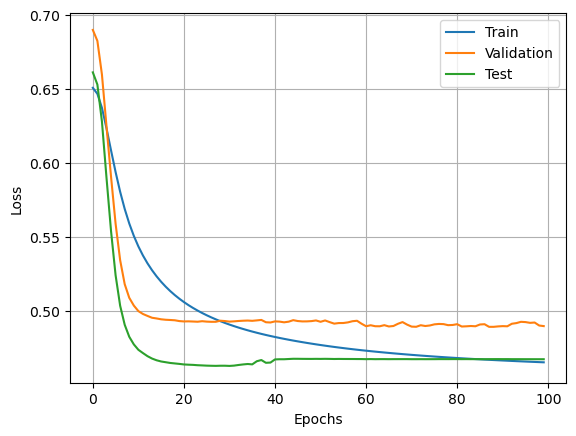

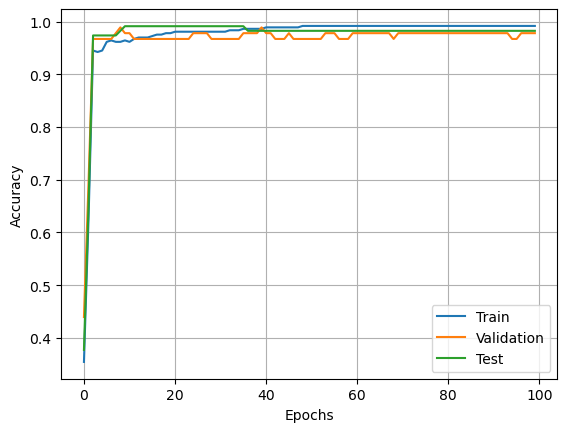

Train Loss:  0.4654097844095348
Validation Loss:  0.48986307441533267
Test Loss 0.46749549476723923
Train Accuracy:  0.9917582417582418
Validation Accuracy:  0.978021978021978
Test Accuracy 0.9824561403508771


In [5]:
loss_fn = nn.BCEWithLogitsLoss()
lr = 1e-4
epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ann_model, train_loss, val_loss, test_loss, train_accuracy, val_accuracy, test_accuracy = train(ANN_Model(len(X[0]) , 1).to(device), loss_fn, lr, epochs, train_loader, val_loader, test_loader)

# Make predictions

In [6]:
index = 500
scaler = StandardScaler()
scaler.fit(X_train)
x_index = X[index]
x_input = scaler.transform(np.array([x_index]))
x_input = torch.tensor(x_input, dtype = torch.float32)
x_input = x_input.to(device)
y_index = Y[index]
y_output = torch.tensor(y_index, dtype = torch.float32).reshape(-1,1)
y_output = y_output.to(device)

ann_model.eval()
with torch.no_grad():
    prediction = ann_model(x_input)
    loss = loss_fn(prediction, y_output)
    prediction_round = prediction.round().cpu().numpy()
    y_output = y_output.cpu().numpy()
    accuracy = accuracy_score(y_output, prediction_round)
    
print("Features: ", x_index)
print("Features scale: ", x_input.tolist())
print("Target: ", y_index)
print("Prediction: ", float(prediction))
print("Accuracy: ", accuracy)
print("Loss: ", loss.item())

Features:  [1.504e+01 1.674e+01 9.873e+01 6.894e+02 9.883e-02 1.364e-01 7.721e-02
 6.142e-02 1.668e-01 6.869e-02 3.720e-01 8.423e-01 2.304e+00 3.484e+01
 4.123e-03 1.819e-02 1.996e-02 1.004e-02 1.055e-02 3.237e-03 1.676e+01
 2.043e+01 1.097e+02 8.569e+02 1.135e-01 2.176e-01 1.856e-01 1.018e-01
 2.177e-01 8.549e-02]
Features scale:  [[0.33008041977882385, -0.6410687565803528, 0.34734004735946655, 0.1688959002494812, 0.17895206809043884, 0.6310933232307434, -0.11847485601902008, 0.39453643560409546, -0.5417401194572449, 0.8515349626541138, -0.10117735713720322, -0.7132002711296082, -0.2924163043498993, -0.09745519608259201, -0.9617335796356201, -0.4278942048549652, -0.38439878821372986, -0.274813175201416, -1.2512742280960083, -0.22458337247371674, 0.1608978807926178, -0.8929826021194458, 0.12105152755975723, 0.01003673579543829, -0.8249239921569824, -0.2300354391336441, -0.4057101011276245, -0.15106114745140076, -1.1945756673812866, 0.08245238661766052]]
Target:  1
Prediction:  0.999998

# Confusion Matrix

In [7]:
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = True)
y_test = []
y_pred = []
for i, data in enumerate(test_loader, 0):
    x_input, y_output = data
    x_input = x_input.to(device = device)
    y_output = y_output.to(device = device).reshape(-1,1)
    with torch.no_grad():
        prediction = ann_model(x_input)
        loss = loss_fn(prediction, y_output)
        y_output = y_output.cpu().numpy()
        prediction = prediction.round().cpu().numpy()
        y_test.append(int(y_output))
        y_pred.append(float(prediction))

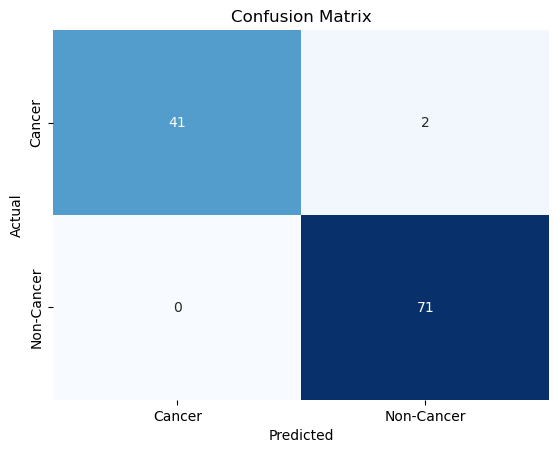

In [8]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Cancer', 'Non-Cancer']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve

In [9]:
from sklearn.metrics import roc_curve, auc
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = True)
y_test = []
y_pred = []
for i, data in enumerate(test_loader, 0):
    x_input, y_output = data
    x_input = x_input.to(device = device)
    y_output = y_output.to(device = device).reshape(-1,1)
    with torch.no_grad():
        prediction = ann_model(x_input)
        loss = loss_fn(prediction, y_output)
        y_output = y_output.cpu().numpy()
        prediction = prediction.cpu().numpy()
        y_test.append(int(y_output))
        y_pred.append(float(prediction))

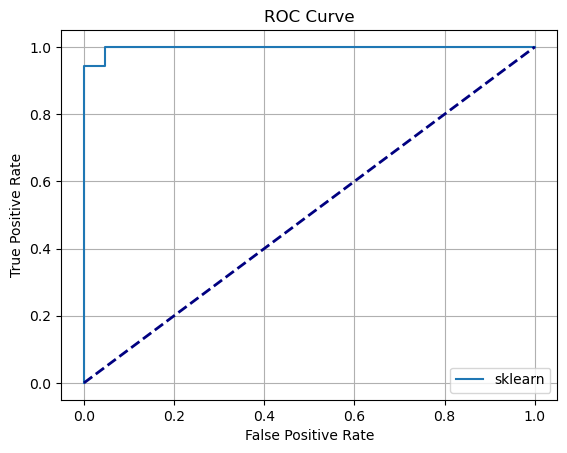

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label = "sklearn")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid()
plt.legend()
plt.savefig('roc_curve_sklearn.png', format='png')
plt.show()

In [11]:
roc_auc = auc(fpr, tpr)
roc_auc

0.99737962659679

# Save model

In [12]:
torch.save(ann_model, "Binary_Classification_Model_Checkpoint.pt")